## Exploration of Caching Data

Within each .mat file is the following:
- `A`: (pixels, neurons) matrix, spatial location of neurons
- `C`: (frames, neurons) matrix of cleaned calcium data
- `CacheFrames`: (num caches,) array, frame in which cache was interacted with (beak poke)
- `CacheFramesEnter`: (num caches,) array; Start frame of hop into each event in `CacheFrames`
- `CacheFramesEnd`: (num caches,) array; End frame of hop out of each event in `CacheFrames`
- `CacheSites`: (num caches,) array, location of each cache event
- `CacheVs`: 
- `IndOnlyCaches`: array, 1-indexed array of whether it was a cache
- `IndOnlyRetrievals`: array, 1-indexed array of whether it was a retrieval
- `S`: (frames, neurons) matrix, deconvolved `C_raw`, activity bursts
- `ThisWasRetrieval`: (num caches,) array, binary array of whether it was a retrieval
- `VS`: Matrix, average s within each visit (hop)
- `VisitDur`: Array, unknown
- `VisitStart`: Array, unknown
- `VisitWedge`: Array, unknown
- `X`: (frames,) array of X locations
- `Y`: (frames,) array of Y locations
- `indCachedMe`: cache seeds eventually retrieved
- `theta`: (frames,) array of theta locations
- `whichWedge`:

Questions:
- For each session, plot cells on the conjunction of normalized place/cache response
- Plot aligned and normalized responses to place and responses to cache

In [1]:
import src.DataFile

ModuleNotFoundError: No module named 'src'

In [4]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
from scipy.io import loadmat
from scipy.stats import gaussian_kde
from scipy import optimize
from math import pi, log2

In [5]:
%matplotlib tk

In [6]:
mat_files = [m for m in os.listdir("data") if m.endswith('mat')]
session_list = pd.read_excel('data/CacheRetrieveSessionList.xlsx', index_col=0)
fps = 20
cmap = cm.get_cmap('viridis')

## Visualizing Bird Trajectory in XY Space

In [10]:
for mat_file in mat_files:
    f = h5py.File("data/" + mat_file, 'r')
    x = np.squeeze(np.array(f['X']))
    y = np.squeeze(np.array(f['Y']))
    x_c, y_c = estimate_center(x, y)
    x -= x_c; y -= y_c
    length = np.sqrt(np.square(x) + np.square(y))
    frames = np.arange(x.size)
    oob = np.logical_or(length <= 145, length >= 215)
    x_oob = x[oob]
    y_oob = y[oob]
    frames_oob = frames[oob]
    x = x[np.logical_not(oob)]
    y = y[np.logical_not(oob)]
    frames = frames[np.logical_not(oob)]
    df_arena = pd.DataFrame({"x":x, "y":y, "frames":frames})
    df_outofbound = pd.DataFrame({"x_oob":x_oob, "y_oob":y_oob, "frames_oob":frames_oob})
    plt.figure()
    ax = plt.gca()
    sns.scatterplot(
        x="x", y="y", hue="frames", size=0.1, data=df_arena, alpha=0.4,
        palette=sns.color_palette("Blues", n_colors=x.size),
        legend=False, ax=ax)
    sns.scatterplot(
        x="x_oob", y="y_oob", hue="frames_oob", size=0.1, data=df_outofbound, alpha=0.4,
        palette=sns.color_palette("Greys", n_colors=x_oob.size),
        legend=False, ax=ax)
    plt.gca().set_aspect("equal")
    plt.xticks([]); plt.yticks([])
    plt.xlabel(""); plt.ylabel("")
    plt.show()

## Visualizing Bird Trajectory in $\theta$

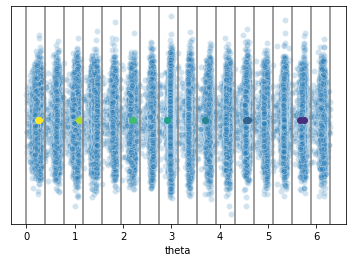

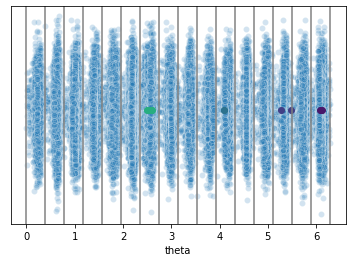

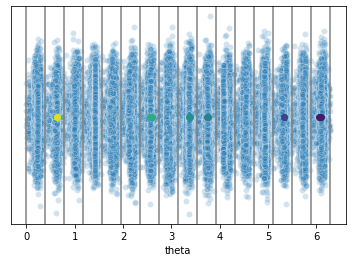

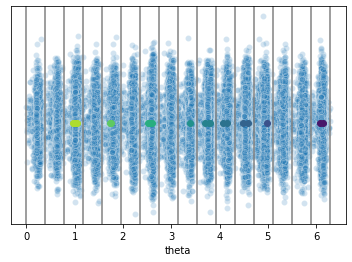

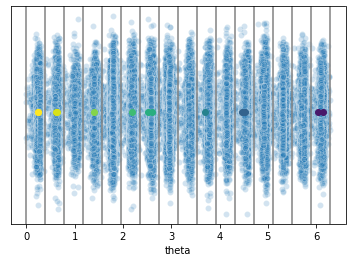

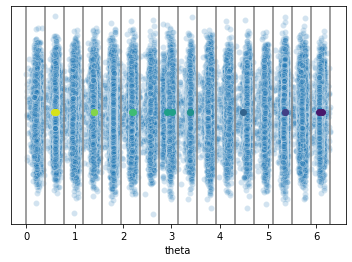

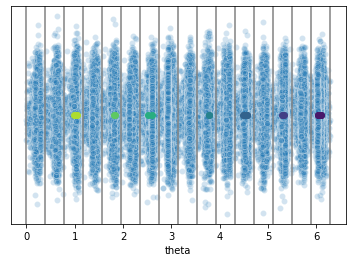

In [157]:
for mat_file in mat_files:
    f = h5py.File("data/" + mat_file, 'r')
    x, y, frames = get_xy(f)
    theta = np.mod(get_theta(x, y), 2*pi)
    df = pd.DataFrame({
        "theta":theta, "frames":frames,
        "zeros":np.random.normal(0, 4, frames.size)
        })
    boundaries = np.linspace(0, 2*pi, 16, endpoint=False)
    boundaries = np.append(boundaries, [2*pi])
    CacheSites = np.array(f['CacheSites']).squeeze()
    CacheFrames = np.array(f['CacheFrames']).squeeze()
    cmap = cm.get_cmap('viridis')
    plt.figure()
    sns.scatterplot(
        x="theta", y="zeros", alpha=0.2, data=df
        )
    for boundary in boundaries:
        plt.axvline(boundary, color="gray")
    for idx, cache in enumerate(CacheSites):
        frame = np.argwhere(frames == CacheFrames[idx])[0,0]
        rgba = cmap(cache/16.)
        plt.scatter(theta[frame], 0, color=rgba)
    plt.yticks([]); plt.ylabel("")
    plt.show()

## Bird Velocity

In [9]:
for mat_file in mat_files:
    f = h5py.File("data/" + mat_file, 'r')
    CacheSites = np.array(f['CacheSites']).squeeze()
    x, y, frames = get_xy(f, in_bound=False)
    delta_x = x[1:] - x[:-1]
    delta_y = y[1:] - y[:-1]
    frames = frames[1:]
    velocity = np.sqrt(np.square(delta_x) + np.square(delta_y)) # pixels/frame
    velocity = velocity*fps # pixels/s
    smoothing_kernel = np.ones(fps)/fps
    velocity = np.convolve(velocity, smoothing_kernel, "valid")
    frames = frames[:velocity.size]
    time = (frames/fps)/60
    CacheSites = np.array(f['CacheSites']).squeeze()
    CacheFramesEnter = np.array(f['CacheFramesEnter']).squeeze()
    CacheFramesExit = np.array(f['CacheFramesExit']).squeeze()
    ThisWasRetrieval = np.array(f['ThisWasRetrieval'])
    plt.figure(figsize=(20,4))
    plt.scatter(time[::2], velocity[::2], s=0.7, alpha=0.5)
    for idx, cache in enumerate(CacheSites):
        time_enter = (CacheFramesEnter[idx]/fps)/60
        time_exit = (CacheFramesExit[idx]/fps)/60
        rgba = cmap(cache/16.)
        alpha = 0.5 if ThisWasRetrieval[idx] else 0.25
        plt.axvspan(time_enter, time_exit, color=rgba, alpha=alpha)
    plt.xlabel("Minutes")
    plt.ylabel("Velocity (pixels/s)")
    plt.show()

## Comparing $C_{raw}$, $C$, $S$

In [18]:
for mat_file in mat_files:
    f = h5py.File("data/" + mat_file, 'r')
    C_raw = np.array(f['C_raw'])
    C = np.array(f['C'])
    S = np.array(f['S'])
    num_frames, num_neurons = C.shape
    time = (np.arange(num_frames)/fps)/60
    start_frame = 10000
    frame_length = 5000
    neur = np.random.choice(num_neurons)
    fig, axs = plt.subplots(3, 1, figsize=(21, 7))
    axs[0].plot(C_raw[start_frame:start_frame+frame_length, neur])
    axs[1].plot(C[start_frame:start_frame+frame_length, neur])
    axs[2].plot(time[start_frame:start_frame+frame_length], S[start_frame:start_frame+frame_length, neur])
    axs[2].set_xlabel("Minutes")
    axs[0].set_xticks([]); axs[1].set_xticks([])
    axs[0].set_yticks([]); axs[1].set_yticks([]); axs[2].set_yticks([])
    plt.show()
    print("\n\n")

## Spike-rate as a function of time

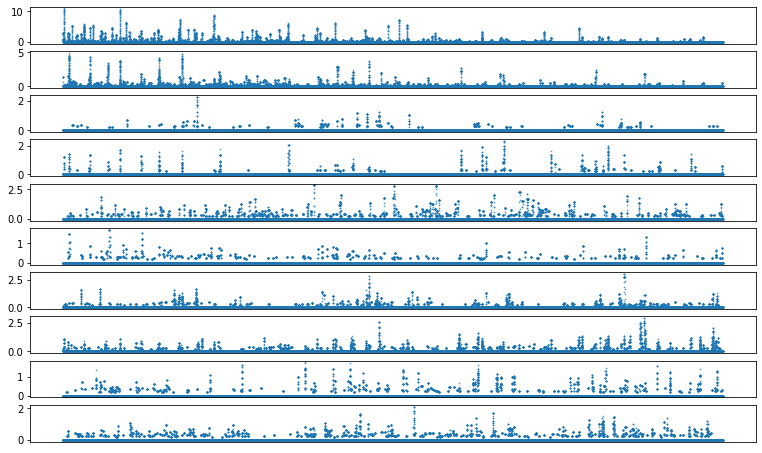

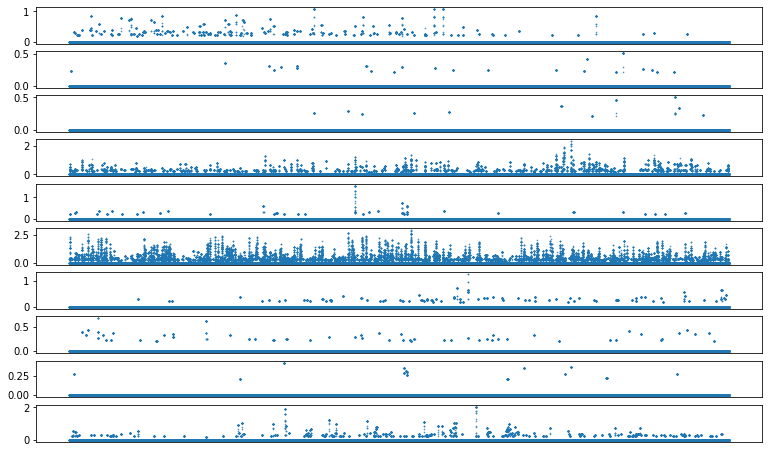

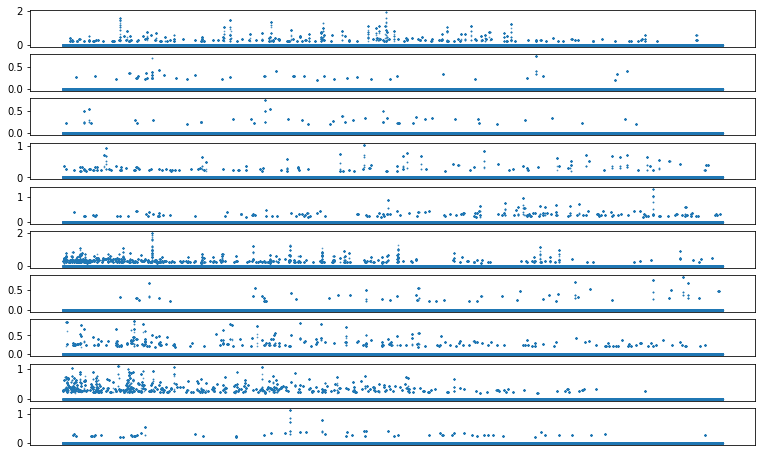

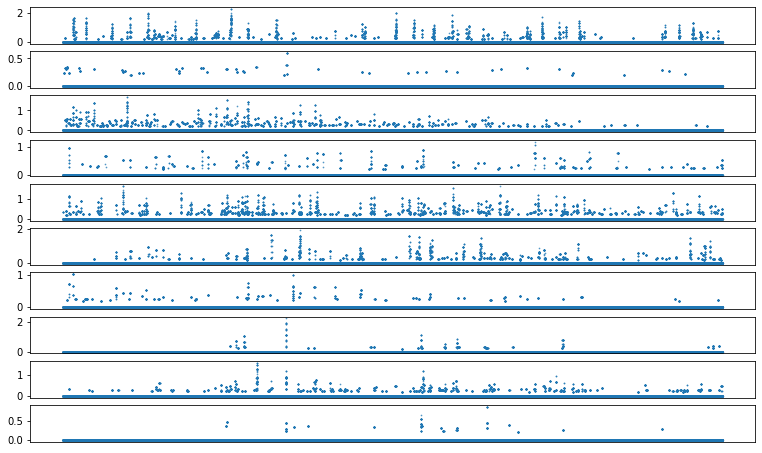

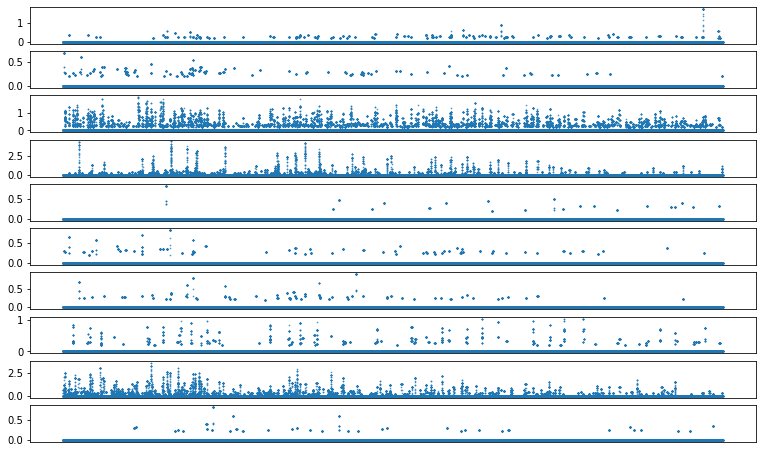

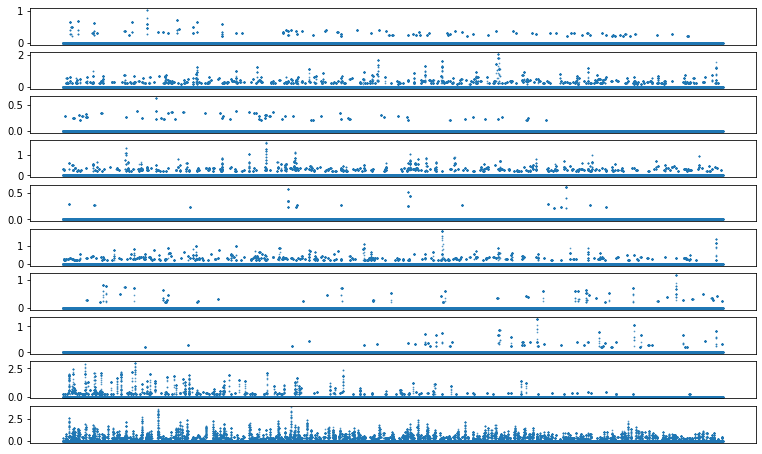

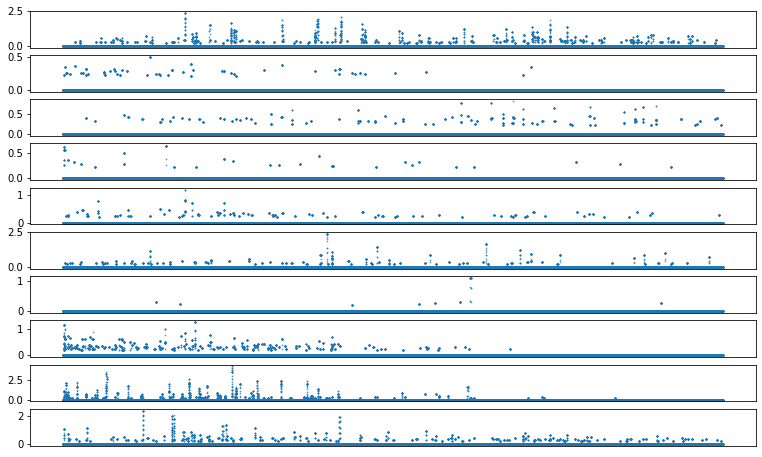

In [176]:
for mat_file in mat_files:
    f = h5py.File("data/" + mat_file, 'r')
    S = np.array(f['S'])
    num_frames, num_neurons = S.shape
    fig, axs = plt.subplots(10, 1, figsize=(13,8))
    neurs = np.random.choice(num_neurons, size=10, replace=False)
    for idx, ax in enumerate(axs):
        neur = neurs[idx]
        spikes = S[:,neur]
        smoothing_kernel = np.ones(fps)/fps # One sec smoothing
        spikesHz = np.convolve(spikes, smoothing_kernel, "valid")
        frames = np.arange(num_frames)[:spikesHz.size]
        ax.scatter(frames, spikesHz, s=0.5, alpha=0.7)
        ax.set_xticks([])
    plt.show()

## Spike-rate as a function of velocity

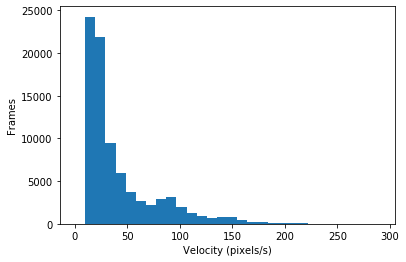

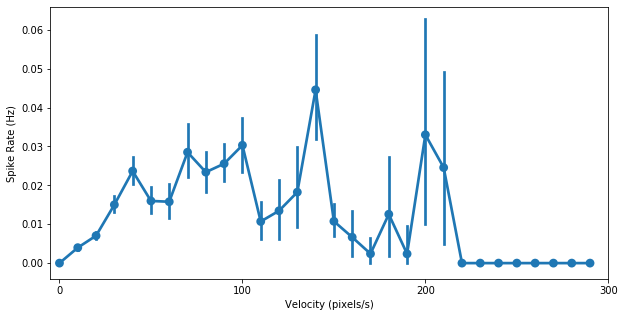

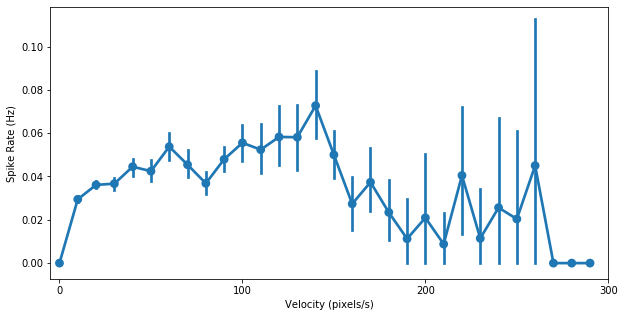

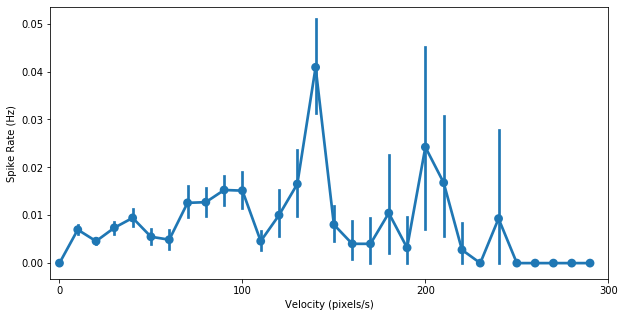

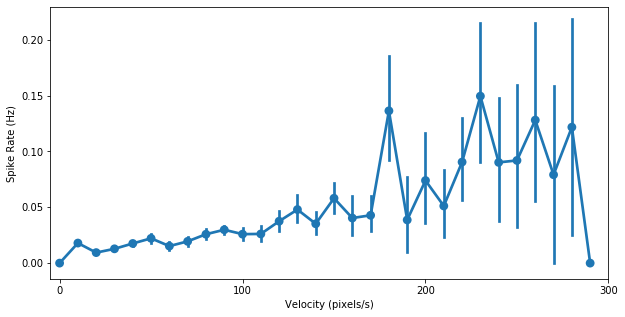

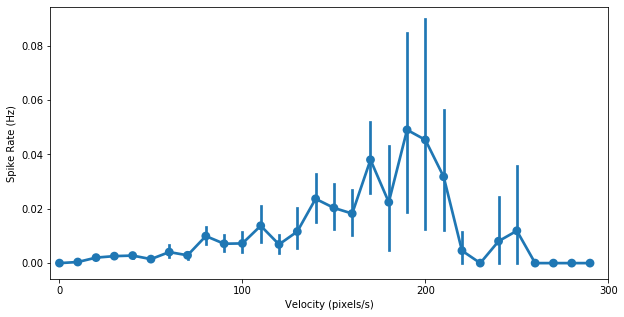

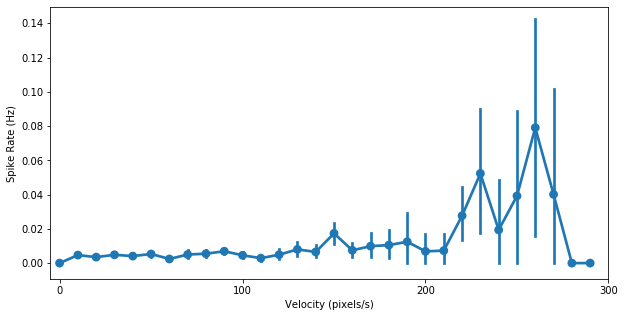

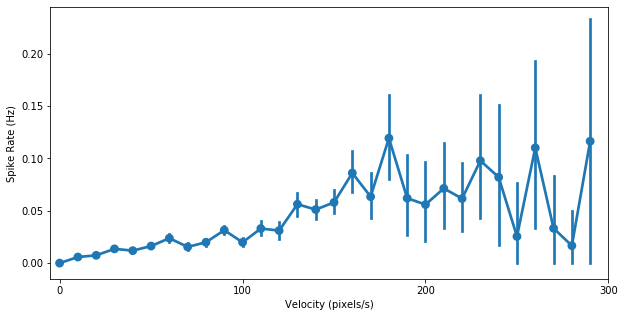

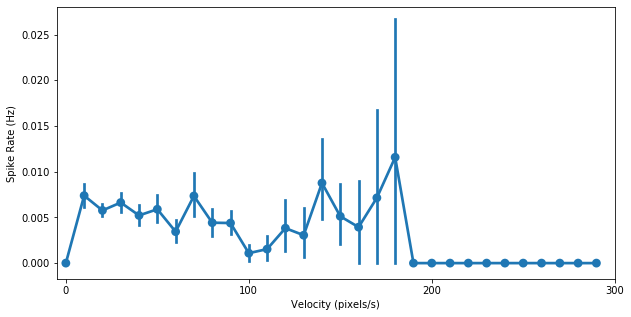

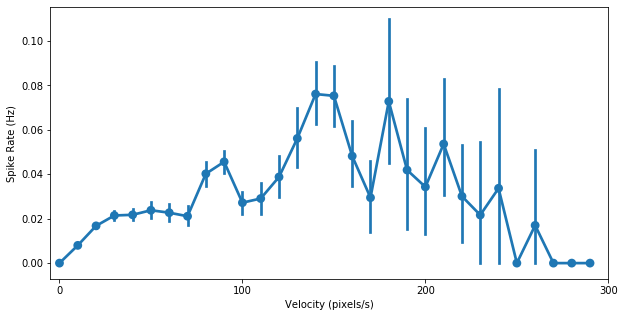

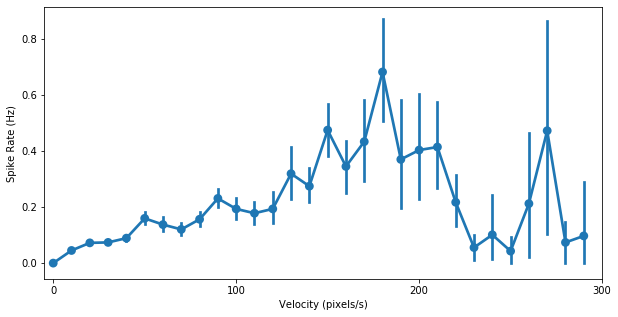

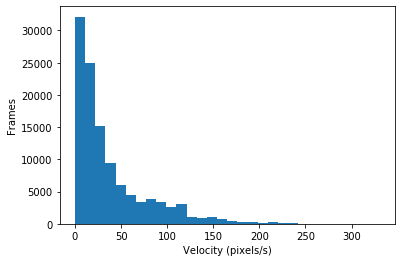

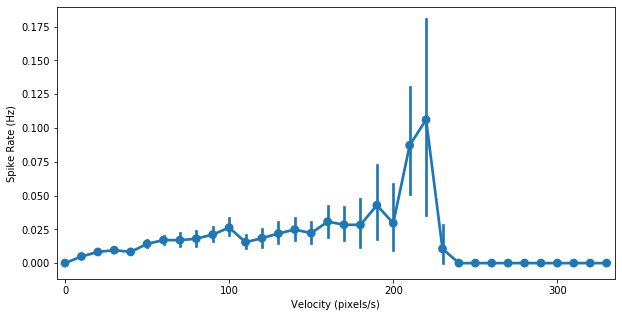

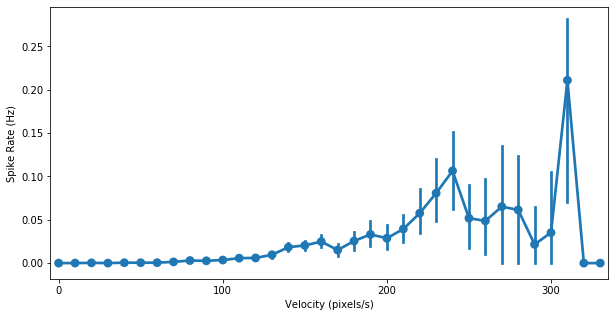

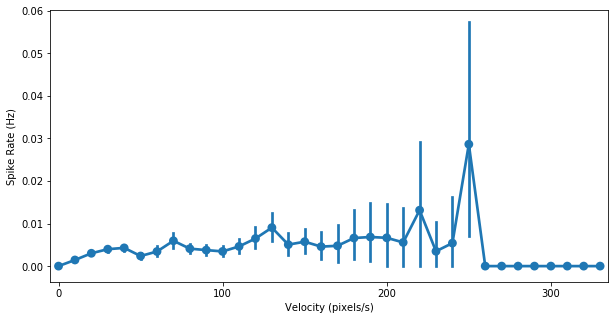

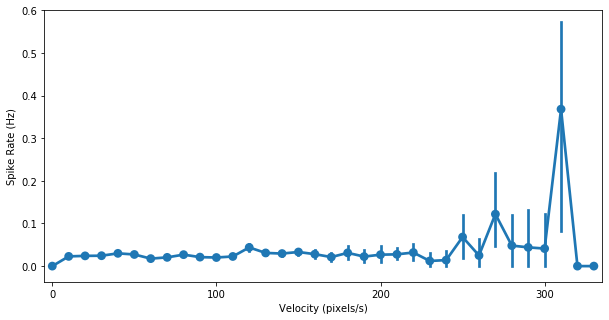

KeyboardInterrupt: 

<Figure size 720x360 with 0 Axes>

In [21]:
for mat_file in mat_files:
    f = h5py.File("data/" + mat_file, 'r')
    velocity, velframes = get_velocity(f)
    velocity = (np.ceil(velocity / 10.0)*10)
    S = np.array(f['S'])
    num_frames, num_neurons = S.shape
    neurs = np.random.choice(num_neurons, size=10, replace=False)
    plt.figure()
    plt.hist(velocity, bins=30)
    plt.ylabel("Frames")
    plt.xlabel("Velocity (pixels/s)")
    plt.show()
    for neur in neurs:
        spikes = S[:,neur]
        smoothing_kernel = np.ones(fps)/fps # One sec smoothing
        spikesHz = np.convolve(spikes, smoothing_kernel, "valid")
        spikes_frames = np.arange(num_frames)[:spikesHz.size]
        spikesHz = spikesHz[spikes_frames[velframes]]
        df = pd.DataFrame({"velocity":velocity, "spikerate":spikesHz})
        plt.figure(figsize=(10,5))
        sns.pointplot(x="velocity", y="spikerate", data=df)
        plt.xticks([0,10,20,30], [0, 100, 200, 300])
        plt.xlabel("Velocity (pixels/s)")
        plt.ylabel("Spike Rate (Hz)")
        plt.show()

## Spike-rate as a function of wedge

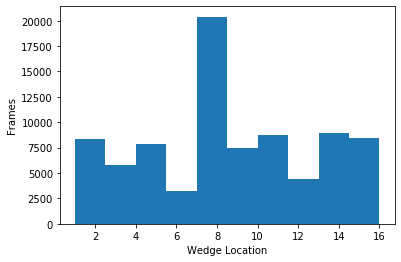

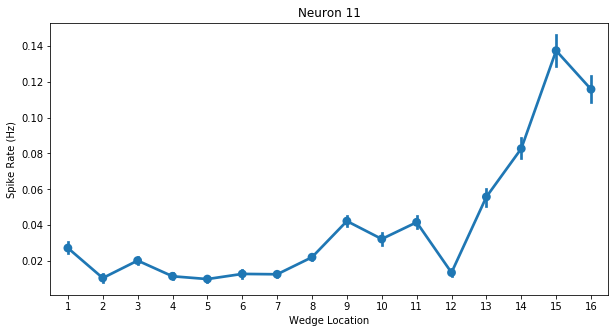

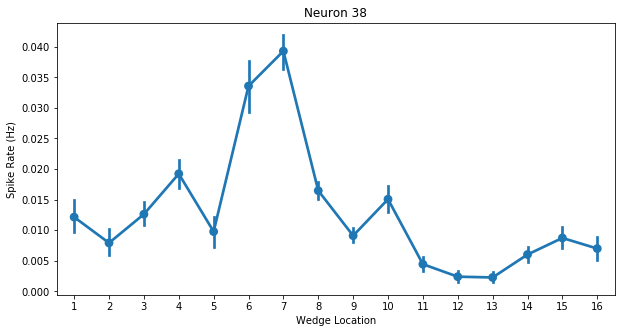

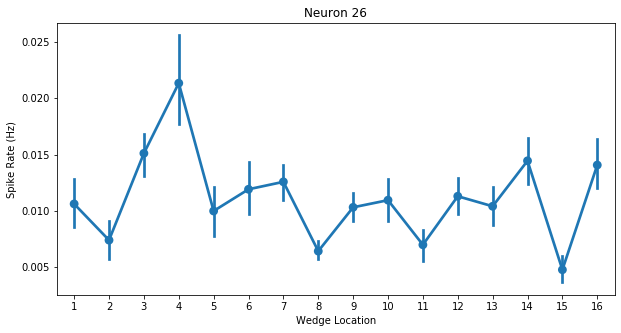

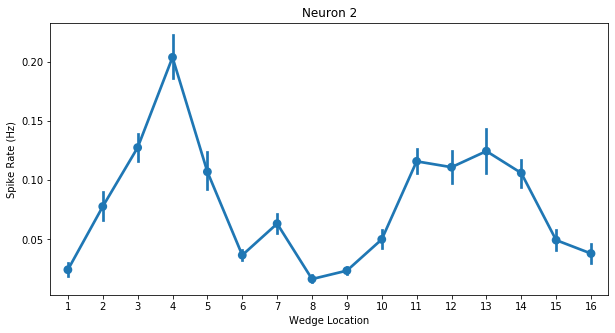

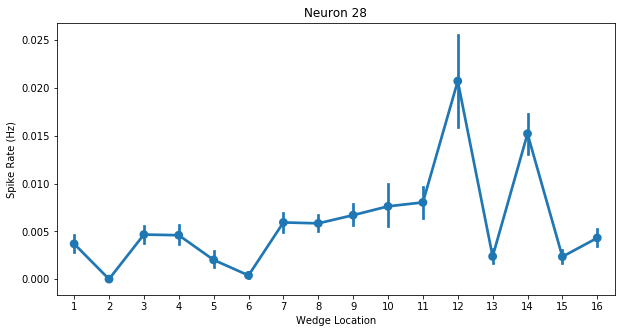

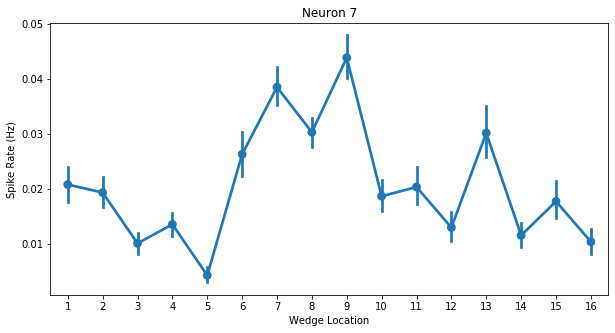

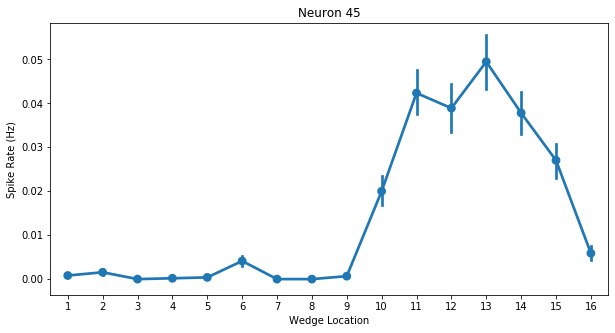

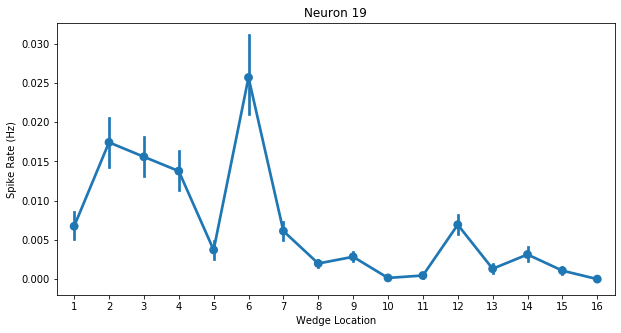

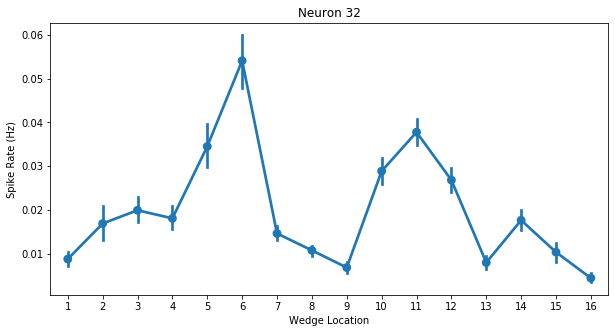

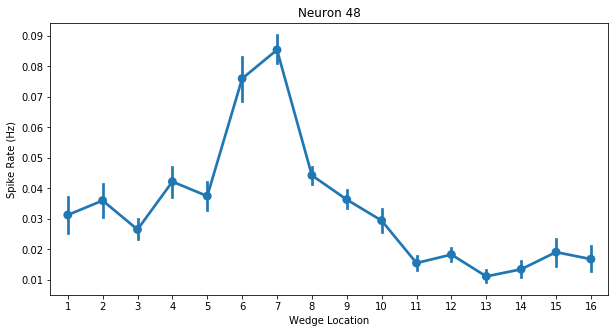

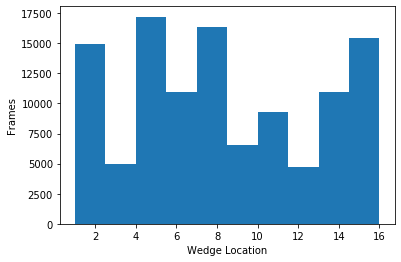

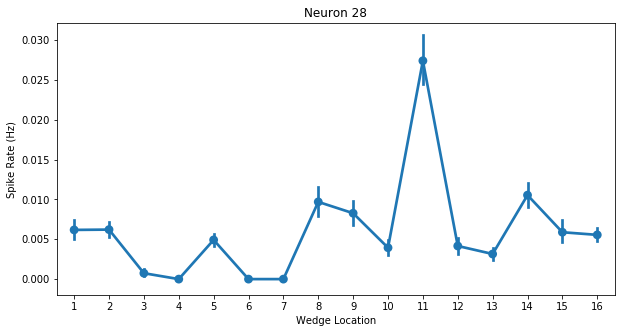

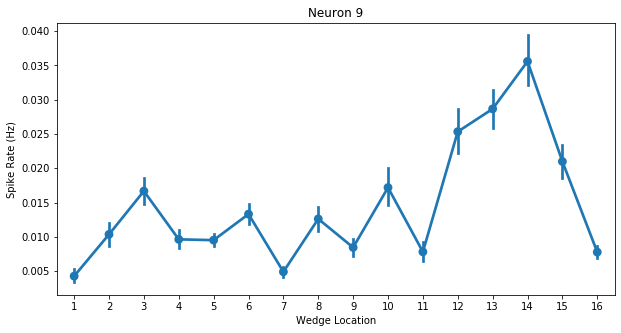

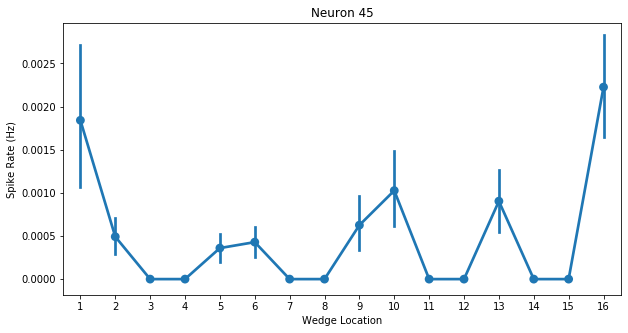

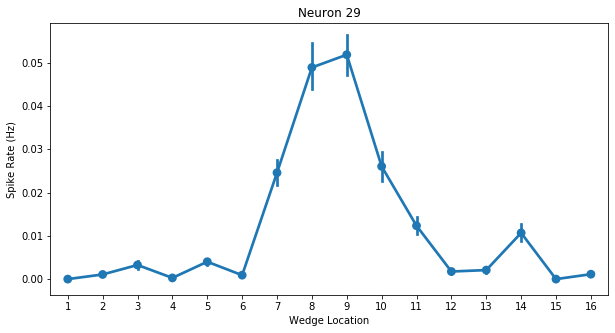

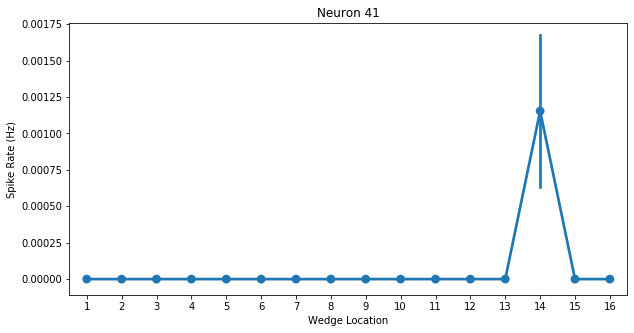

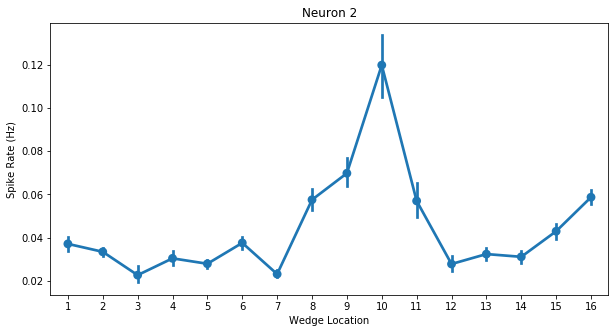

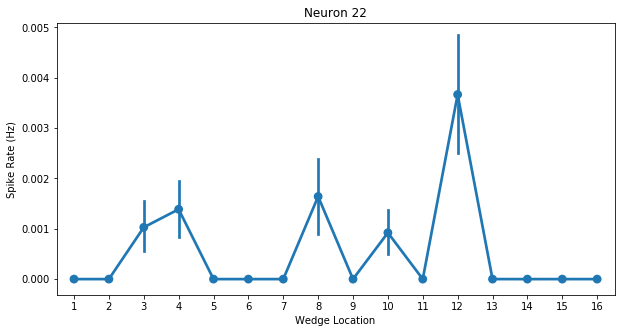

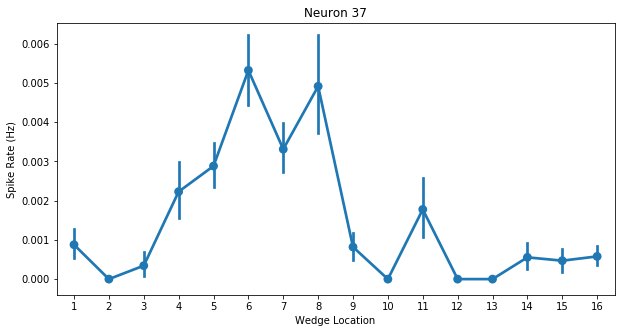

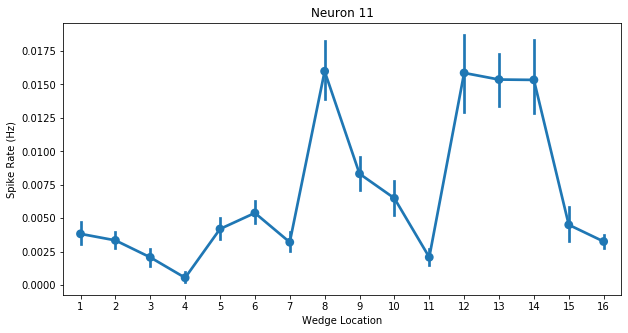

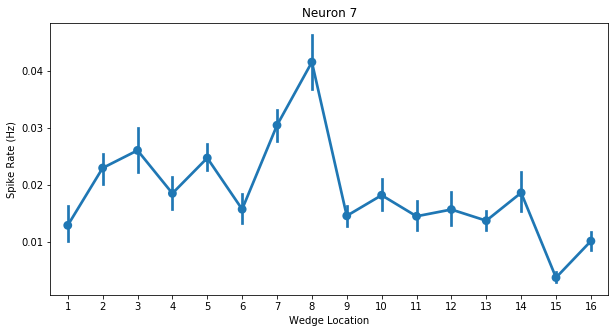

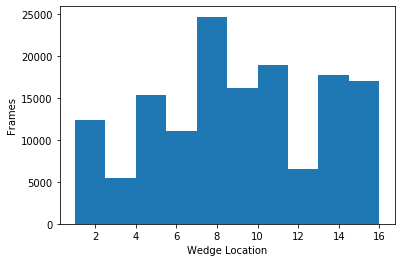

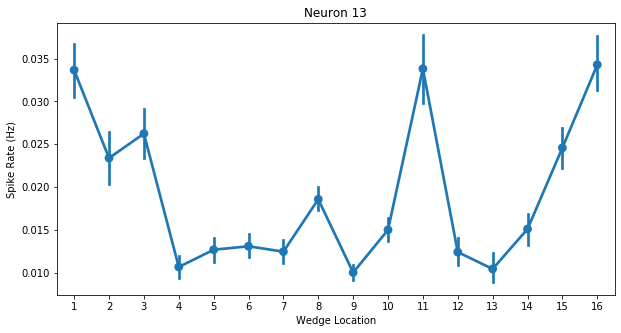

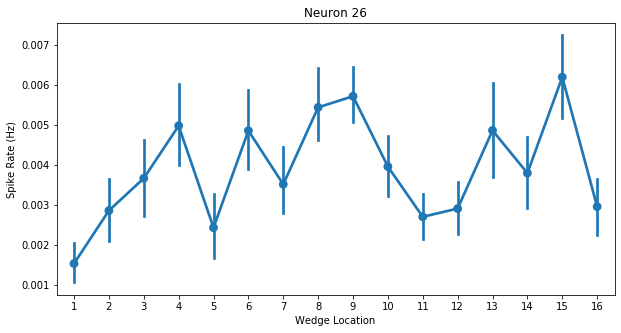

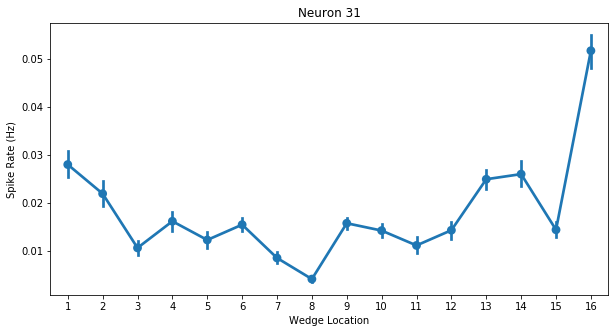

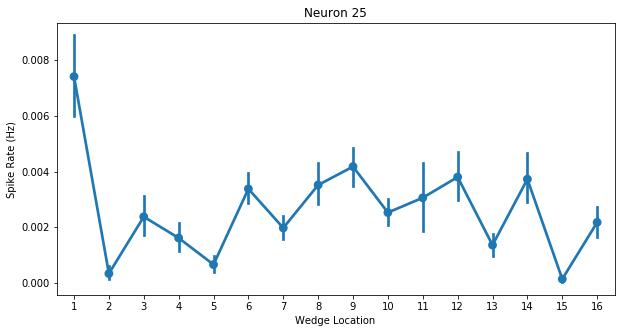

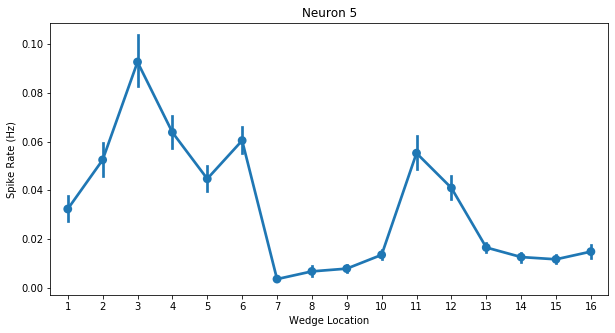

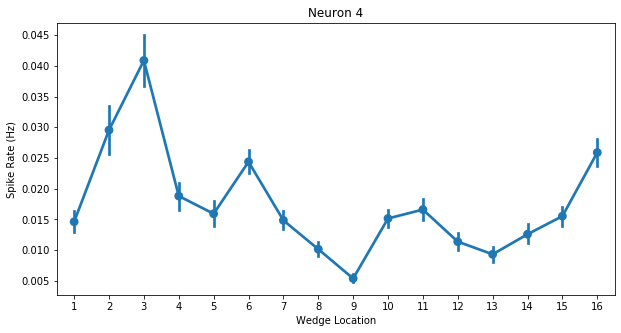

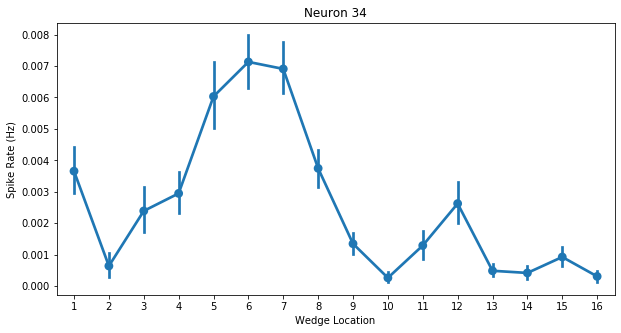

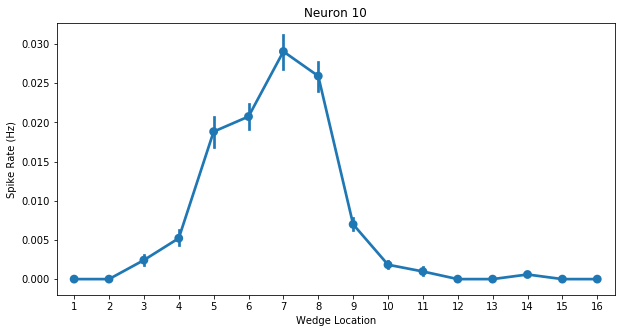

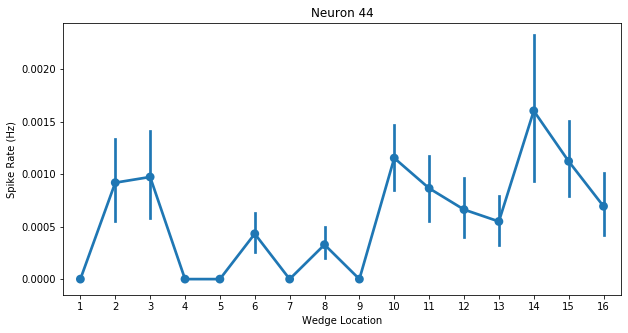

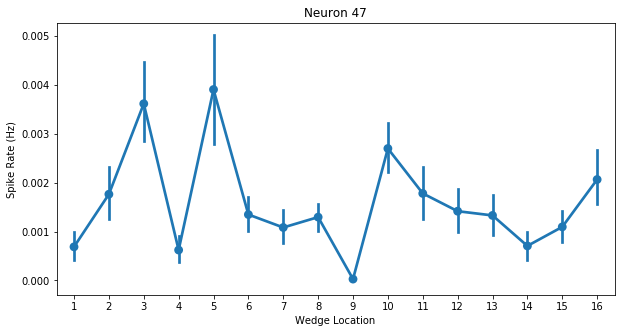

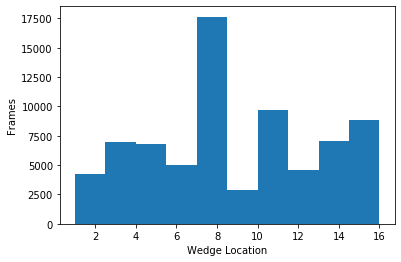

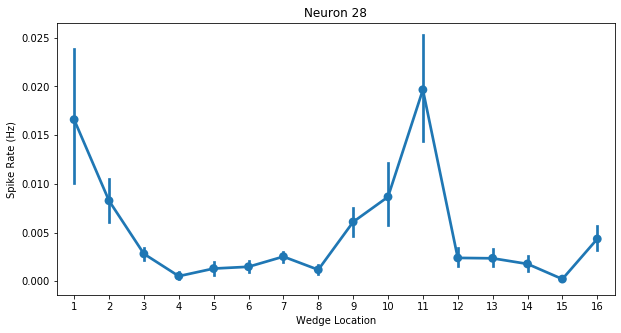

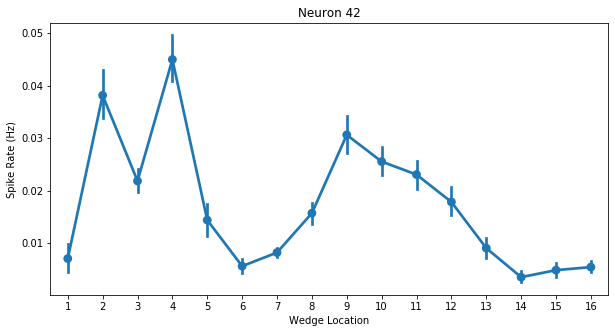

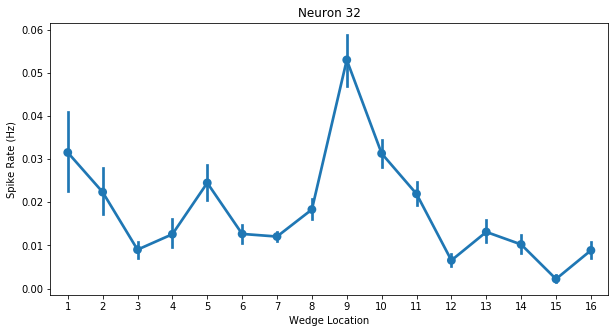

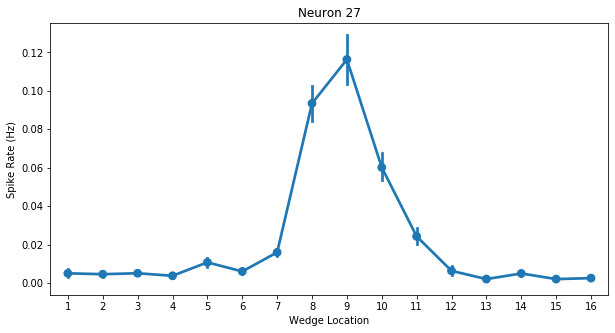

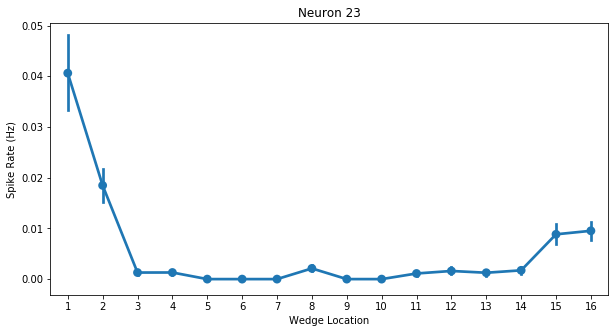

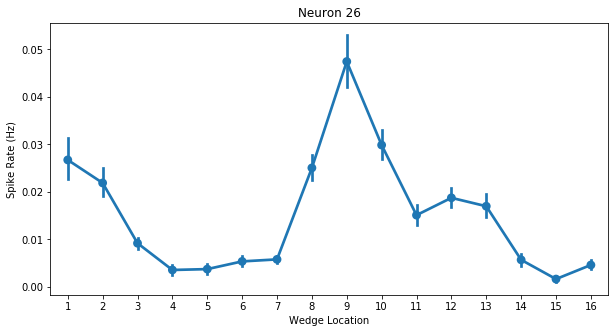

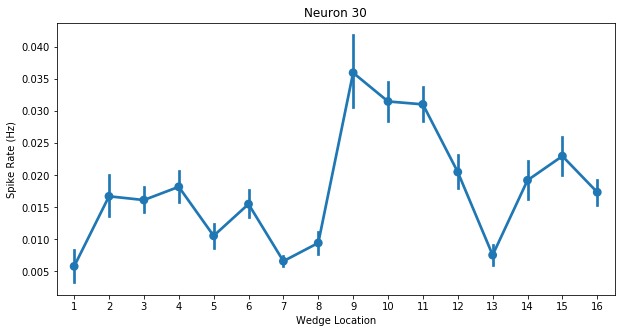

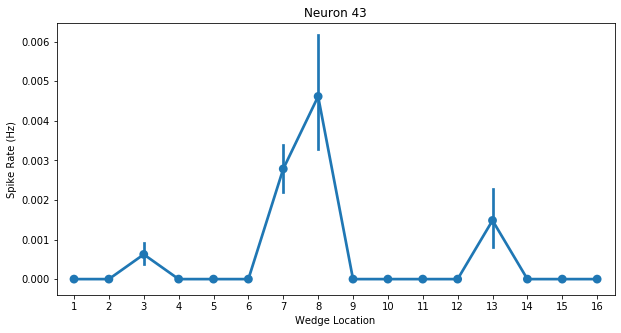

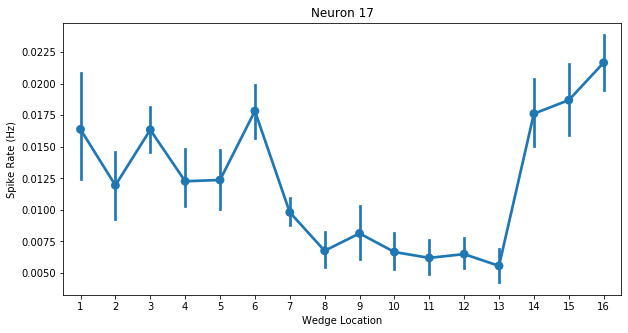

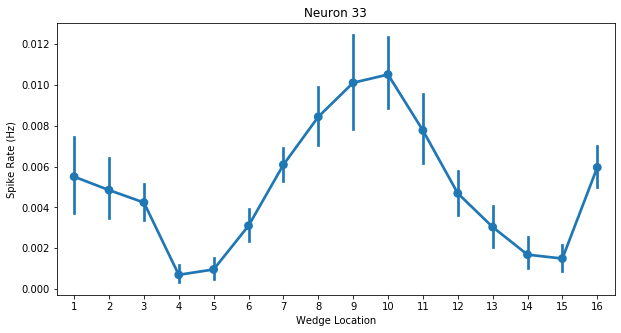

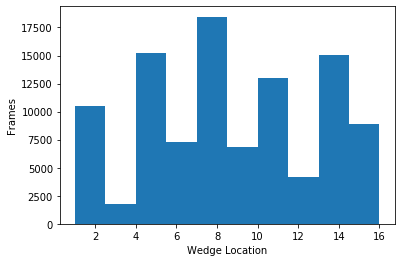

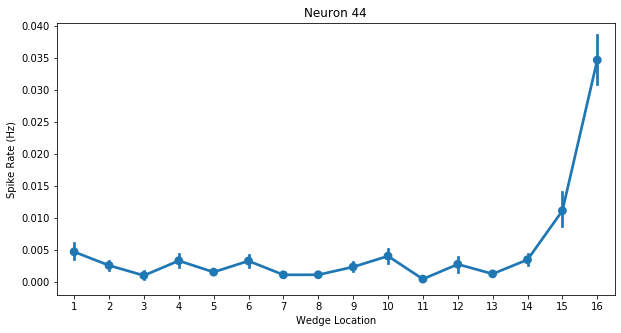

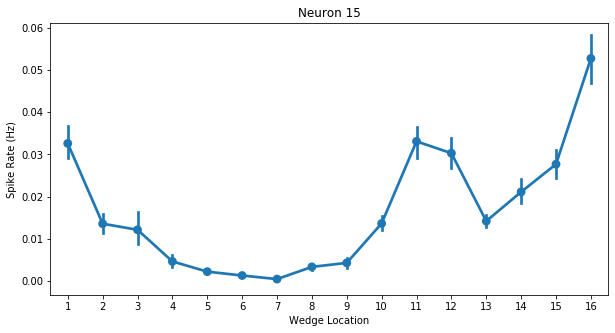

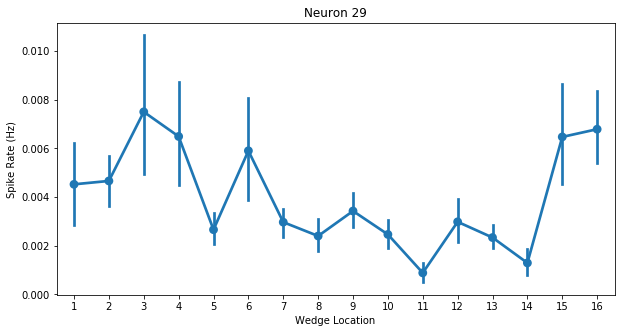

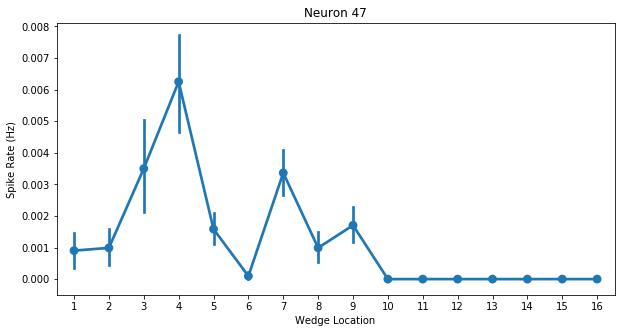

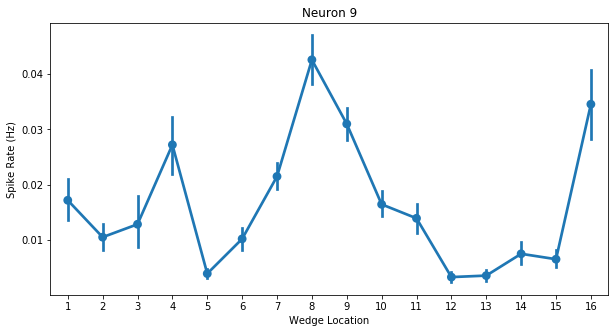

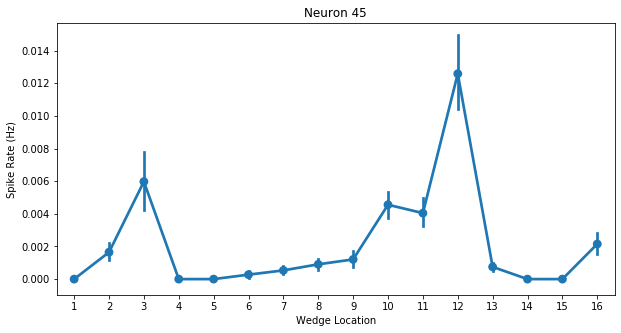

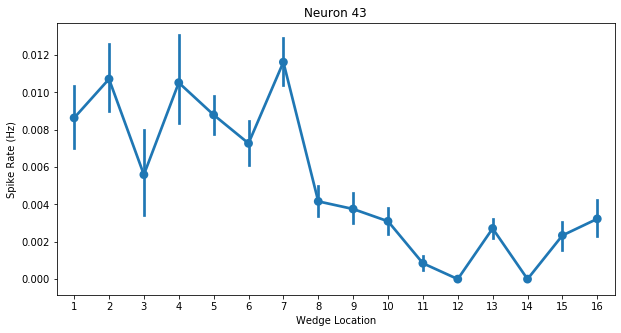

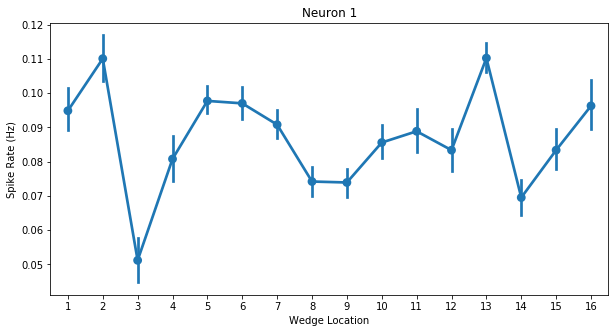

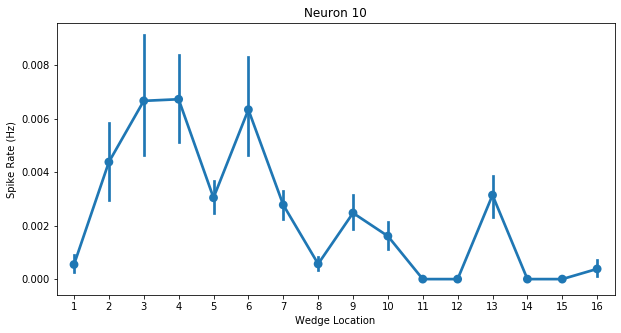

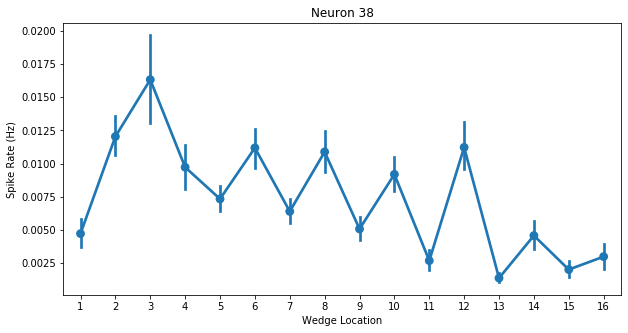

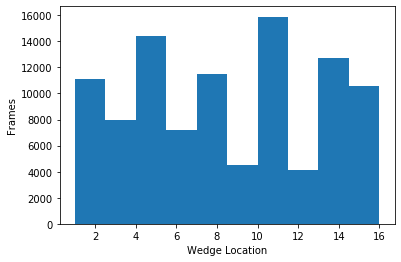

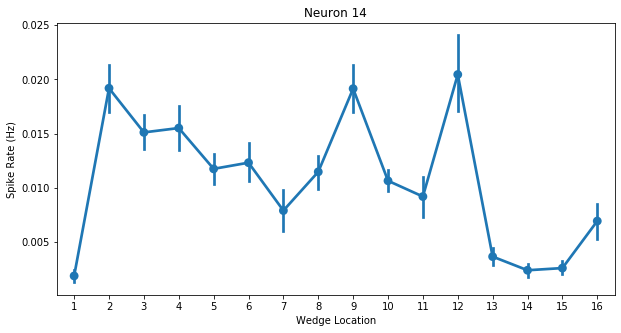

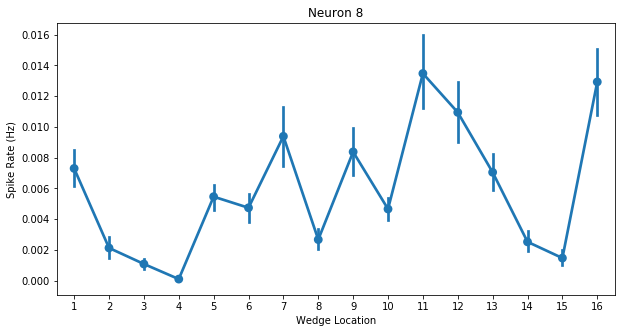

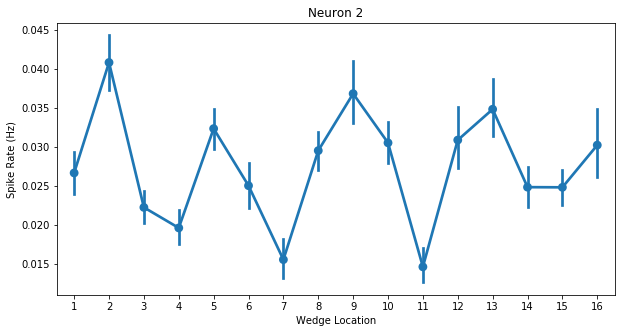

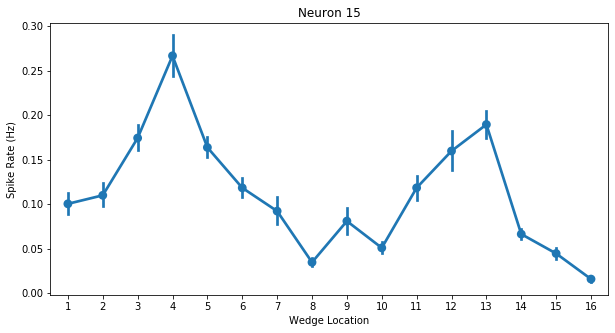

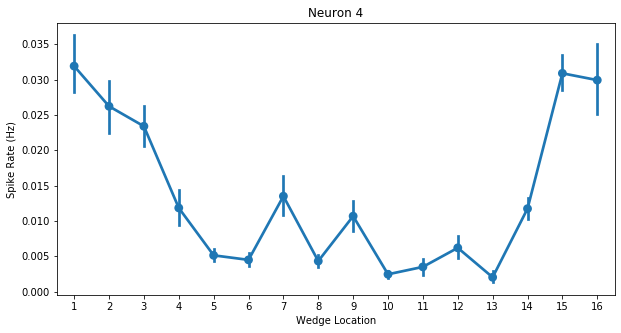

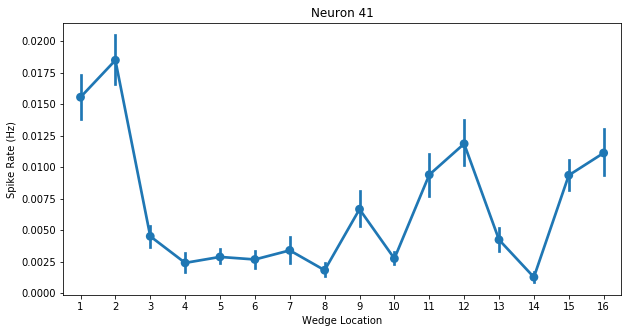

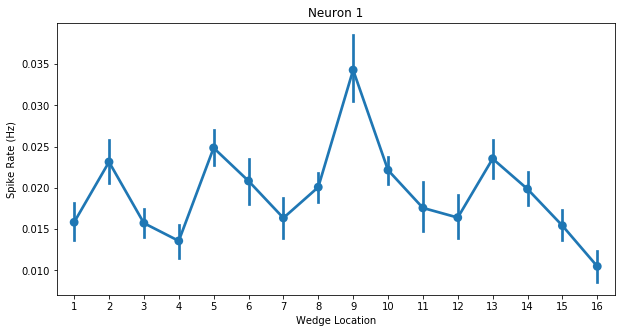

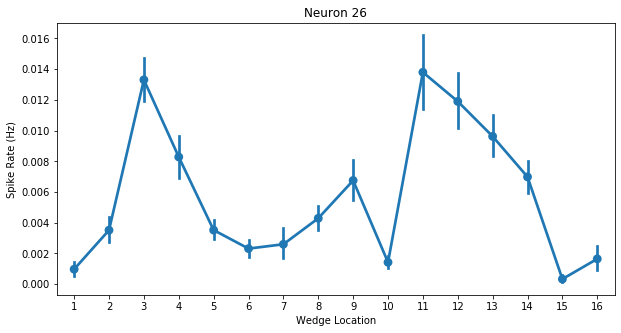

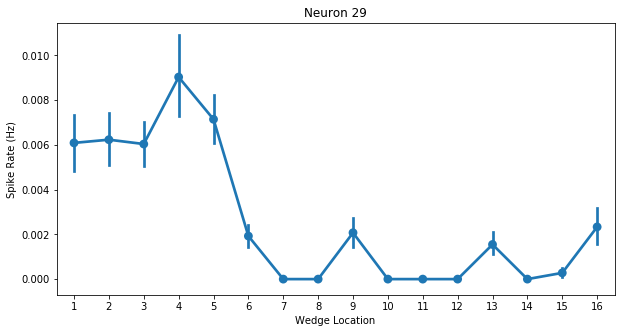

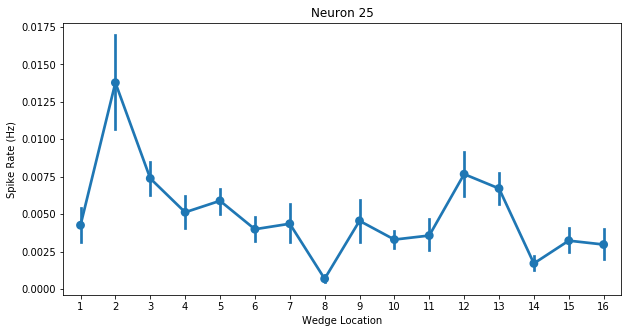

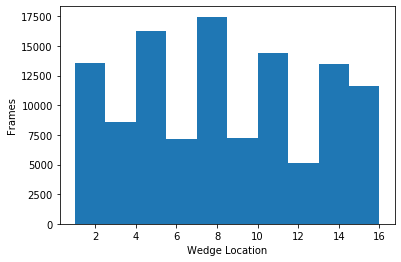

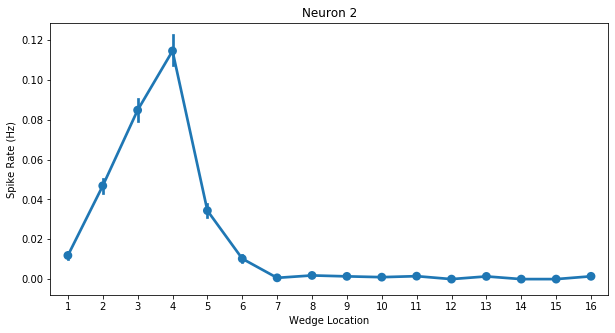

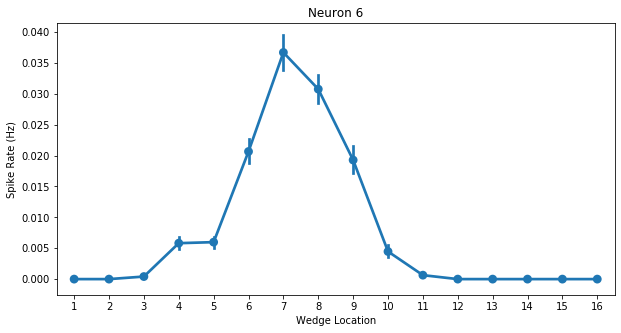

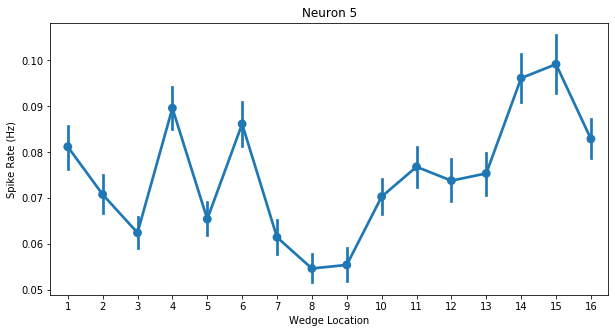

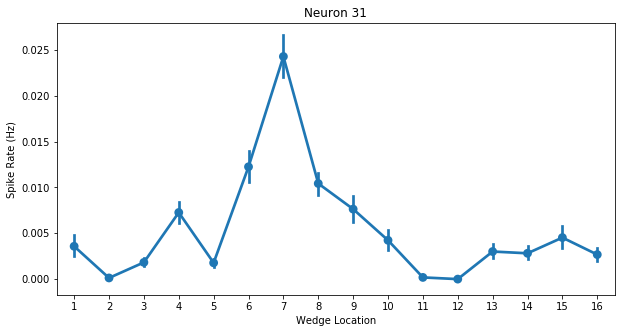

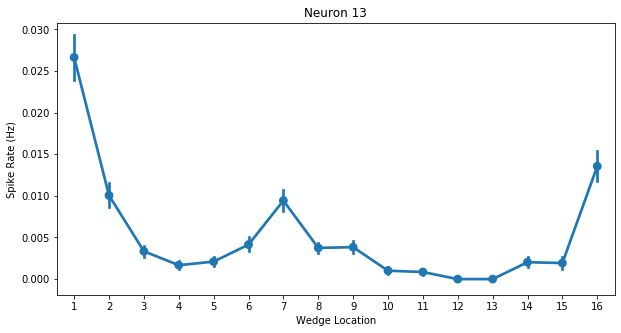

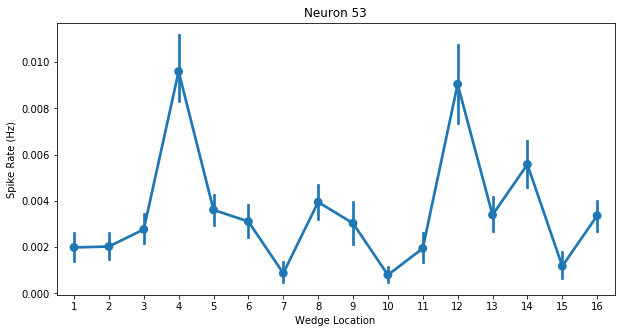

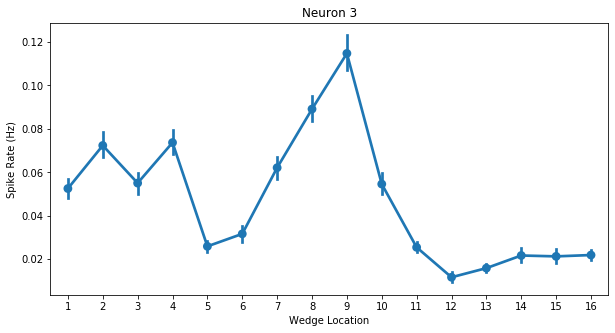

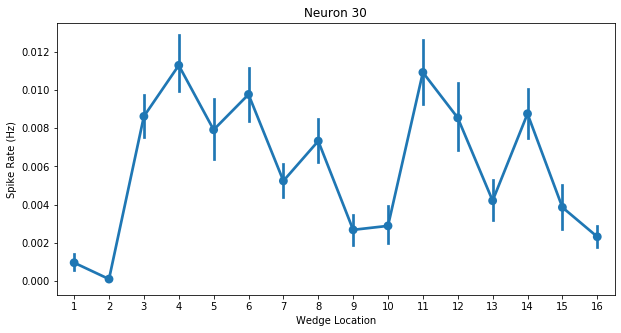

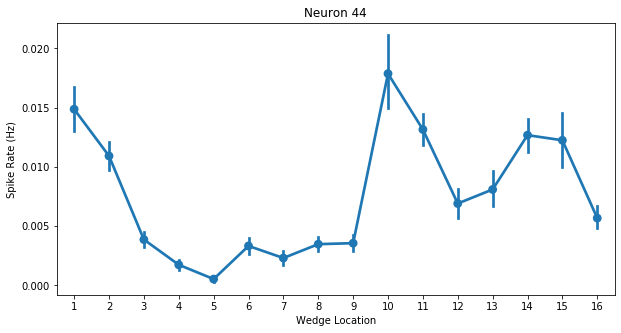

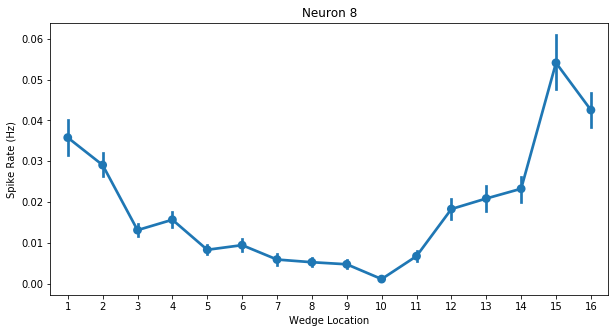

In [46]:
for mat_file in mat_files:
    f = h5py.File("data/" + mat_file, 'r')
    wedges, wedge_frames = get_wedges(f)
    S = np.array(f['S'])
    num_frames, num_neurons = S.shape
    neurs = np.random.choice(num_neurons, size=10, replace=False)
    plt.figure()
    plt.hist(wedges)
    plt.ylabel("Frames")
    plt.xlabel("Wedge Location")
    plt.show()
    for neur in neurs:
        spikes = S[:,neur]
        smoothing_kernel = np.ones(fps)/fps # One sec smoothing
        spikesHz = np.convolve(spikes, smoothing_kernel, "valid")
        spike_frames = np.arange(num_frames)[:spikesHz.size]
        valid_frames = np.intersect1d(spike_frames, wedge_frames)
        df = pd.DataFrame({
            "wedge":wedges[np.isin(wedge_frames, valid_frames)],
            "spikerate":spikesHz[np.isin(spike_frames, valid_frames)]
            })
        plt.figure(figsize=(10,5))
        sns.pointplot(x="wedge", y="spikerate", data=df)
        plt.xlabel("Wedge Location")
        plt.ylabel("Spike Rate (Hz)")
        plt.title("Neuron %d"%neur)
        plt.show()

## Generating Behavior

In [24]:
mat_file = mat_files[0]
f = h5py.File("data/" + mat_file, 'r')
wedges, wedge_frames = get_wedges(f)
x, y, xy_frames = get_xy(f)
theta = np.mod(get_theta(x, y), 2*pi)
velocity, vel_frames = get_velocity(f)
valid_frames = np.intersect1d(xy_frames, vel_frames)
theta = theta[np.isin(xy_frames, valid_frames)]
velocity = velocity[np.isin(vel_frames, valid_frames)]


In [25]:
with open("session_thetas.p", "wb") as p:
    pickle.dump(theta, p)

# Plotting trial-by-trial neural activity

In [11]:
for mat_file in mat_files:
    f = h5py.File("data/" + mat_file, 'r')
    CacheFrames = np.array(f['CacheFrames'])
    IndOnlyCaches = np.array(f['IndOnlyCaches']).astype(int) - 1
    IndOnlyRetrievals = np.array(f['IndOnlyRetrievals']).astype(int) - 1
    cache_frames = CacheFrames[IndOnlyCaches].astype(int)
    retrievals_frames = CacheFrames[IndOnlyRetrievals].astype(int)
    x, y, theta_frames = get_xy(f)
    theta = np.mod(get_theta(x, y), 2*pi)
    S = np.array(f['S'])
    num_frames, num_neurons = S.shape
    neurs = np.arange(num_neurons)#np.random.choice(num_neurons, size=10, replace=False)
    for neur in neurs[7:8]:
        spikes = S[:,neur]
        smoothing_kernel = np.ones(fps)/fps # One sec smoothing
        spikesHz = np.convolve(spikes, smoothing_kernel, "valid")
        spike_frames = np.arange(num_frames)[:spikesHz.size]
        valid_frames = np.intersect1d(spike_frames, theta_frames)
        neur_theta = theta[np.isin(theta_frames, valid_frames)]
        neur_fr = spikesHz[np.isin(spike_frames, valid_frames)]
        neur_fr/=neur_fr.max()
        plt.figure(figsize=(8,10))
        plt.scatter(
            neur_theta, -valid_frames, color="gray",
            alpha=0.2
            )
        plt.scatter(
            neur_theta[neur_fr > 0], -valid_frames[neur_fr > 0],
            c=neur_fr[neur_fr > 0], cmap="Reds", alpha=0.6
            )
        plt.scatter(
            neur_theta[cache_frames], -cache_frames, s=70, marker="*",
            color="blue", alpha=0.7
            )
        plt.scatter(
            neur_theta[retrievals_frames], -retrievals_frames, s=70, marker="x",
            color="blue", alpha=0.7
            )
        plt.ylabel("Time in Arena")
        mins = np.array([20,40,60,80,100,120])
        plt.yticks(-fps*60*mins, mins)
        plt.xlabel("Location in Arena")
        plt.xticks([0, pi, 2*pi], ["0", "\u03C0", "2\u03C0"])
        plt.title("Neuron %d"%neur)
        plt.show()
    break